 # Imports and getting data

In [1]:
import urllib
import urllib.request
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
matplotlib.style.use('default')
matplotlib.rcParams['figure.figsize'] = (24, 12)
from itertools import cycle


In [2]:
!pip install periodictable pyamtrack lmfit

In [3]:
import periodictable
from pyamtrack import libAT
from lmfit import  Model, Parameters

In [4]:
# astropy needed to support units
import astropy
from astropy import units as u
from astropy import constants as const

In [5]:
# create new units based on [MeV / u]
eV_u = u.def_unit('eV/u', u.eV / u.u)
keV_u = u.def_unit('keV/u', u.keV / u.u)
MeV_u = u.def_unit('MeV/u', u.MeV / u.u)
GeV_u = u.def_unit('GeV/u', u.GeV / u.u)
Gy = u.def_unit('Gy', u.J / u.kg)

u.add_enabled_units([eV_u, keV_u, MeV_u, GeV_u, Gy])

# shortcut for dimensionless unit
dimless = u.dimensionless_unscaled

In [7]:
e_test_MeV_u = np.geomspace(start = 10 * eV_u, stop = 500 * MeV_u, num = 1000000)

In [6]:
@u.quantity_input
def glet(E_MeV_u : MeV_u, Z : dimless, libamtrack : bool = False) -> u.keV/u.um:
    """
    Calculates the stopping power (LET) of the projectile in liquid water
    :param energy: Energy in [MeV/u]
    :param z: Charge of projectile. e.g. 6 for Carbon ions.
    :param libamtrack: calculate using libamtrack library
    :returns: LET in [keV/um]
    """
    if not isinstance(Z, astropy.units.quantity.Quantity):
      Z <<= dimless
    if Z.isscalar and not E_MeV_u.isscalar:
      Z = np.ones(E_MeV_u.shape) * Z

    if libamtrack:
      material_no = libAT.material_no.Water_Liquid.value
      stop_power_source_no = libAT.stoppingPowerSource_no.PSTAR.value
      particle_no = 1000*Z + Z
      if E_MeV_u.isscalar:
        particle_no = [int((1000*Z + Z).to_value(dimless))]
        list_E_MeV_u = [E_MeV_u.to_value(MeV_u)]
        result = [0.]
      else:
        particle_no = [int(z) for z in (1000*Z + Z).to_value(dimless)]
        list_E_MeV_u = E_MeV_u.to_value(MeV_u).tolist()
        result = np.zeros(E_MeV_u.shape).tolist()
      libAT.AT_Stopping_Power_with_no(
          libAT.stoppingPowerSource_no.PSTAR.value,
          list_E_MeV_u,
          particle_no,
          libAT.material_no.Water_Liquid.value,
          result
      )
      if E_MeV_u.isscalar:
        result = result[0]
      let_keV_um = result << u.keV / u.um
    else:
      # proton mass stopping power (in [MeV cm^2 /g]) as function of energy (in [MeV/u]) 
      # is piece-wise approximated by polynomials 
      # approximation is defined on intervals separated by following valeues: 60 keV/u, 10 MeV/u, 1 GeV/u
      p1 = np.poly1d([-0.328797e-2, -0.869548e-1, -0.911414e0, -0.471453e1, -0.115638e2, -0.374474e1])
      p2 = np.poly1d([0.649495e-3, 0.141793e-2, -0.108231e-1, 0.190340e-2, 0.886293e-3, -0.712500e0, 0.553740e1])
      p3 = np.poly1d([0.113600e-2, -0.501344e-2, -0.210655e-1, -0.670708e0, 0.549002e1])
      p4 = np.poly1d([-0.232769e-1, 0.618546e0, -0.541066e1, 0.163141e2])
      log_E_MeV_u = np.log(E_MeV_u.to_value(MeV_u)) # convert to plain floating point numbers (log of energy)
      rlet = np.piecewise(log_E_MeV_u,
                          condlist=[E_MeV_u <= 60. * keV_u, 
                                    (E_MeV_u > 60. * keV_u) & (E_MeV_u <= 10. * MeV_u),
                                    (E_MeV_u > 10. * MeV_u) & (E_MeV_u <= 1. * GeV_u),
                                    E_MeV_u > 1. * GeV_u],
                          funclist=[p1, p2, p3, p4])
      proton_mass_stop_power = np.exp(rlet) << u.MeV * u.cm**2 / u.g # apply exp function and convert back to quantity objects

      # ion mass stopping power is calculated from proton mass stopping power by rescaling by effective charge
      beta = e2beta(E_MeV_u)
      zeff_proton = zeff(Z=1, beta=beta)
      zeff_ion = zeff(Z=Z, beta=beta)
      ion_mass_stop_power = (zeff_ion / zeff_proton)**2 * proton_mass_stop_power

      # ion stopping power (LET) is calculated by scaling with water density
      water_density = 1.0 * u.g / u.cm**3
      let_keV_um = ion_mass_stop_power * water_density
    
    return let_keV_um

In [8]:
def get_file(token, fname):
  url = "http://cernbox.cern.ch/index.php/s/{:s}/download".format(token)
  with urllib.request.urlopen(url) as response:
      with open(fname, 'wb') as file:
        file.write(response.read())

In [9]:
get_file("WFLi5YzC04zEnJt", "ion_raw_data.dat")

In [10]:
get_file("abvsxcKL9eqhRVS", "photon_raw_data.dat")

In [11]:
get_file("5EFiuOFf6sxUfjG", "pide.xlsx")

In [12]:
pide_df = pd.read_excel('pide.xlsx')

In [13]:
def ion_range_cm( ion_name, energy_MeV_u):
  ion_code = libAT.AT_particle_no_from_particle_name_single(ion_name)
  material_name = "Water, Liquid"
  material_code = libAT.AT_material_number_from_name(material_name)
  return libAT.AT_CSDA_range_g_cm2_single(energy_MeV_u, 0, ion_code, material_code)


In [14]:
pide_df['IonRange_cm'] = pide_df.apply(lambda x : ion_range_cm(x.Ion, x.Energy), axis=1)

In [15]:
pide_df.columns

Index(['#ExpID', '#Publication', 'PublicationName', '#IonExp', 'Cells',
       'CellClass', 'CellOrigin', 'CellCycle', 'DNAcontent', 'PhotonRadiation',
       '#PhotonExp', 'Ion', 'Charge', 'IrradiationConditions', 'LET', 'Energy',
       'ax_paper', 'bx_paper', 'ai_paper', 'bi_paper', 'ax_fit', 'bx_fit',
       'ai_fit', 'bi_fit', 'IonRange_cm'],
      dtype='object')

In [16]:
pide_df[pide_df.ax_paper <= 0]

,#ExpID,#Publication,PublicationName,#IonExp,Cells,CellClass,CellOrigin,CellCycle,DNAcontent,PhotonRadiation,#PhotonExp,Ion,Charge,IrradiationConditions,LET,Energy,ax_paper,bx_paper,ai_paper,bi_paper,ax_fit,bx_fit,ai_fit,bi_fit,IonRange_cm
300,301,14,suzuki00,7,U-251MGKO,t,h,a,6.0,200kVp,7,12C,6,m,13.3,271.2,-0.0825,0.09533,0.109,0.097,0.0,0.081563,0.109268,0.093851,14.574842
316,317,14,suzuki00,23,U-251MGKO,t,h,a,6.0,200kVp,7,12C,6,m,77.1,25.1,-0.0825,0.09533,0.467,0.189,0.0,0.081563,0.626031,0.145780,0.215210


In [17]:
pide_df['D10x'] = np.nan
pide_df['D10i'] = np.nan

In [18]:
pide_df.loc[pide_df.bx_paper != 0.0, 'D10x'] = ((pide_df.ax_paper * pide_df.ax_paper - 4.0 * pide_df.bx_paper * np.log(0.1))**0.5 - pide_df.ax_paper) / (2.0 * pide_df.bx_paper)
pide_df.loc[pide_df.bx_paper == 0.0, 'D10x'] = np.log(0.1) / ( - pide_df.ax_paper )

In [19]:
pide_df.D10x

0       6.954923
1       6.954923
2       6.954923
3       6.954923
4       6.954923
          ...   
1113    6.909048
1114    6.909048
1115    6.909048
1116    6.909048
1117    6.909048
Name: D10x, Length: 1118, dtype: float64

In [20]:
pide_df.loc[pide_df.bi_paper != 0.0, 'D10i'] = ((pide_df.ai_paper * pide_df.ai_paper - 4.0 * pide_df.bi_paper * np.log(0.1))**0.5 - pide_df.ai_paper) / (2.0 * pide_df.bi_paper)
pide_df.loc[pide_df.bi_paper == 0.0, 'D10i'] = np.log(0.1) / ( - pide_df.ai_paper )

In [21]:
pide_df.D10i

0       6.874115
1       7.493017
2       6.036342
3       6.018422
4       5.940386
          ...   
1113    6.335461
1114    5.520424
1115    4.066138
1116    2.981616
1117    2.322078
Name: D10i, Length: 1118, dtype: float64

In [22]:
pide_df['RBE10'] = pide_df.D10x / pide_df.D10i

In [23]:
pide_df.RBE10

0       1.011755
1       0.928187
2       1.152175
3       1.155606
4       1.170786
          ...   
1113    1.090536
1114    1.251543
1115    1.699167
1116    2.317216
1117    2.975373
Name: RBE10, Length: 1118, dtype: float64

In [24]:
pide_df.drop(columns=['CellClass', 'CellOrigin', 'CellCycle', 'DNAcontent', 'ax_paper', 'bx_paper', 'ai_paper', 'bi_paper', 'ax_fit', 'bx_fit',
       'ai_fit', 'bi_fit', 'D10x', 'D10i'], inplace=True)
pide_df.rename(columns={"LET": "LET_keV_um", "Energy": "E_MeV_u"}, errors="raise", inplace=True)

In [25]:
photon_raw_df = pd.read_csv('photon_raw_data.dat', names = ['row_data'])
photon_raw_df['#ExpID'] = photon_raw_df.row_data.str.split().str[0].astype(int)
photon_raw_df['#Publication'] = photon_raw_df.row_data.str.split().str[1].astype(int)
photon_raw_df['PublicationName'] = photon_raw_df.row_data.str.split().str[2].astype(str)
photon_raw_df['#PhotonExp'] = photon_raw_df.row_data.str.split().str[3].astype(int)
photon_raw_df['ref_doses'] = photon_raw_df.row_data.str.split().str[4::2].apply(lambda  x : [float(y) for y in x if y != 'N/A'])
photon_raw_df['ref_cell_survival'] = photon_raw_df.row_data.str.split().str[5::2].apply(lambda x : [float(y) for y in x if y != 'N/A'])
photon_raw_df['ref_no_doses'] = photon_raw_df.ref_doses.apply( lambda x : len(x))
photon_raw_df['ref_no_cell_survival'] = photon_raw_df.ref_cell_survival.apply( lambda x : len(x))
photon_raw_df.drop(columns=['row_data'], inplace=True)
photon_raw_df.head()

,#ExpID,#Publication,PublicationName,#PhotonExp,ref_doses,ref_cell_survival,ref_no_doses,ref_no_cell_survival
0,1,1,chapman77,1,[],[],0,0
1,2,2,chapman78,1,"[0.62, 1.32, 2.1, 2.87, 4.04, 5.51, 6.95, 8.31...","[0.91201, 0.81283, 0.69183, 0.6166, 0.40738, 0...",10,10
2,3,2,chapman78,2,"[0.66, 1.4, 2.14, 2.91, 3.69, 5.32, 6.95, 7.96...","[0.93325, 0.83176, 0.66069, 0.44668, 0.33884, ...",10,10
3,4,2,chapman78,3,"[0.94, 1.96, 2.98, 3.96, 4.94, 5.96, 6.98, 7.92]","[0.83176, 0.67608, 0.46774, 0.30903, 0.19498, ...",8,8
4,5,3,blakely79,1,"[2.91, 4.617, 4.65, 5.615, 7.365, 7.383, 7.392...","[0.429, 0.1869, 0.2043, 0.0963, 0.0336, 0.0373...",12,12


In [26]:

ion_raw_df = pd.read_csv('ion_raw_data.dat', names = ['row_data'])
ion_raw_df['#ExpID'] = ion_raw_df.row_data.str.split().str[0].astype(int)
ion_raw_df['#Publication'] = ion_raw_df.row_data.str.split().str[1].astype(int)
ion_raw_df['PublicationName'] = ion_raw_df.row_data.str.split().str[2].astype(str)
ion_raw_df['#IonExp'] = ion_raw_df.row_data.str.split().str[3].astype(int)
ion_raw_df['#PhotonExp'] = ion_raw_df.row_data.str.split().str[4].astype(int)
ion_raw_df['ion_doses'] = ion_raw_df.row_data.str.split().str[5::2].apply(lambda  x : [float(y) for y in x if y != 'N/A'])
ion_raw_df['ion_cell_survival'] = ion_raw_df.row_data.str.split().str[6::2].apply(lambda x : [float(y) for y in x if y != 'N/A'])
ion_raw_df['ion_no_doses'] = ion_raw_df.ion_doses.apply( lambda x : len(x))
ion_raw_df['ion_no_cell_survival'] = ion_raw_df.ion_cell_survival.apply( lambda x : len(x))
ion_raw_df.drop(columns=['row_data'], inplace=True)
ion_raw_df.head()

,#ExpID,#Publication,PublicationName,#IonExp,#PhotonExp,ion_doses,ion_cell_survival,ion_no_doses,ion_no_cell_survival
0,1,1,chapman77,1,1,[],[],0,0
1,2,1,chapman77,2,1,[],[],0,0
2,3,1,chapman77,3,1,[],[],0,0
3,4,1,chapman77,4,1,[],[],0,0
4,5,1,chapman77,5,1,[],[],0,0


# V79 filter

In [27]:
print("Entries:" , len(pide_df))
pide_df.head()

Entries: 1118


,#ExpID,#Publication,PublicationName,#IonExp,Cells,PhotonRadiation,#PhotonExp,Ion,Charge,IrradiationConditions,LET_keV_um,E_MeV_u,IonRange_cm,RBE10
0,1,1,chapman77,1,V79,220kVp,1,4He,2,s,2.34,133.4,12.921836,1.011755
1,2,1,chapman77,2,V79,220kVp,1,4He,2,s,2.40,128.8,12.148917,0.928187
2,3,1,chapman77,3,V79,220kVp,1,4He,2,s,7.85,28.1,0.791567,1.152175
3,4,1,chapman77,4,V79,220kVp,1,4He,2,s,8.13,26.9,0.731584,1.155606
4,5,1,chapman77,5,V79,220kVp,1,4He,2,s,9.12,23.4,0.568890,1.170786


In [28]:
v79_df = pide_df[pide_df.Cells == 'V79']
print("Entries:" , len(v79_df))
v79_df.head()

Entries: 320


,#ExpID,#Publication,PublicationName,#IonExp,Cells,PhotonRadiation,#PhotonExp,Ion,Charge,IrradiationConditions,LET_keV_um,E_MeV_u,IonRange_cm,RBE10
0,1,1,chapman77,1,V79,220kVp,1,4He,2,s,2.34,133.4,12.921836,1.011755
1,2,1,chapman77,2,V79,220kVp,1,4He,2,s,2.40,128.8,12.148917,0.928187
2,3,1,chapman77,3,V79,220kVp,1,4He,2,s,7.85,28.1,0.791567,1.152175
3,4,1,chapman77,4,V79,220kVp,1,4He,2,s,8.13,26.9,0.731584,1.155606
4,5,1,chapman77,5,V79,220kVp,1,4He,2,s,9.12,23.4,0.568890,1.170786


In [29]:
for char, x in v79_df.groupby("Charge"):
  print(char)

1
2
3
5
6
7
8
9
10
18
20
26
28
36
54
79
92


In [30]:
cycol = cycle('bgrcmk')

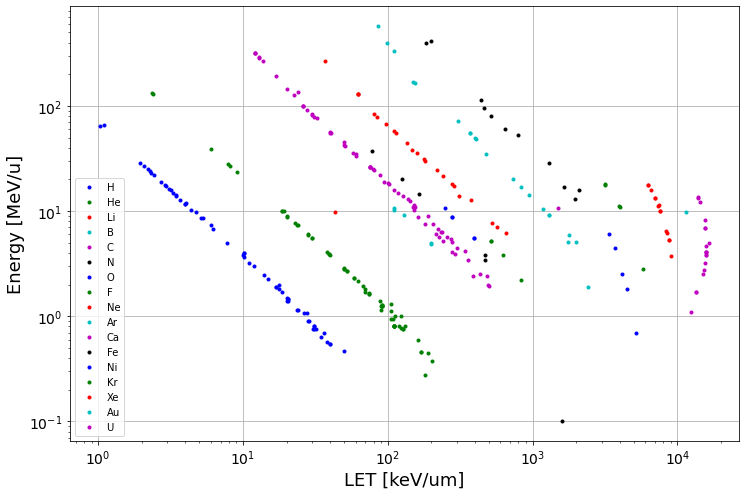

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
for ion_charge, ion_df in v79_df.groupby('Charge'):
  col=next(cycol)
  ion_df.plot('LET_keV_um', 'E_MeV_u', style='.', label="{}".format(periodictable.elements[ion_charge]), ax=ax, color=col);
 #ax.plot(glet(e_test_MeV_u, Z=ion_charge, libamtrack=True),e_test_MeV_u,"-",alpha=0.4,  color=col)
  

ax.set_xlabel('LET [keV/um]',size=18)
ax.set_ylabel('Energy [MeV/u]', size=18)
ax.set_yscale('log')
ax.set_xscale('log')

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

ax.grid();

(0.1, 1000)

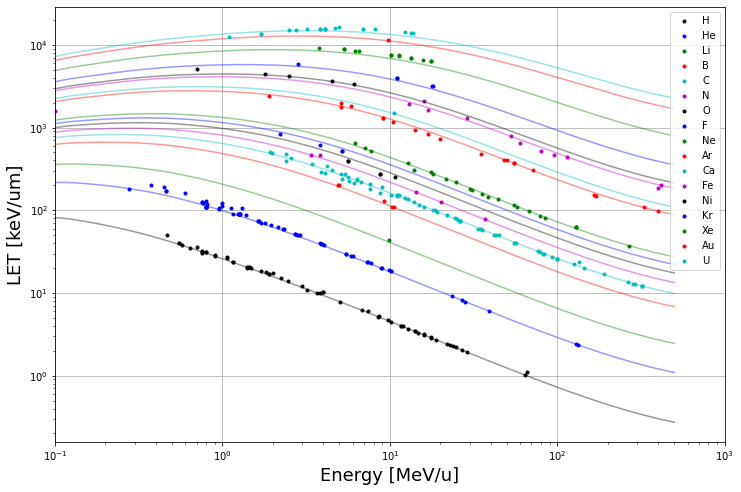

In [65]:
fig, ax = plt.subplots(figsize=(12,8))

for ion_charge, ion_df in v79_df.groupby('Charge'):
  col=next(cycol)
  ion_df.plot( 'E_MeV_u', 'LET_keV_um', style='.', label="{}".format(periodictable.elements[ion_charge]),ax=ax, color=col);
  plt.plot(e_test_MeV_u, glet(e_test_MeV_u, Z=ion_charge, libamtrack=True),"-",alpha=0.4,  color=col)
plt.xscale('log')
plt.yscale('log')  

plt.ylabel('LET [keV/um]',size=18)
plt.xlabel('Energy [MeV/u]', size=18)
plt.grid()

plt.xlim(0.1,1000)

#ax.tick_params(axis='both', which='major', labelsize=14)
#ax.tick_params(axis='both', which='minor', labelsize=14)


<function matplotlib.pyplot.legend>

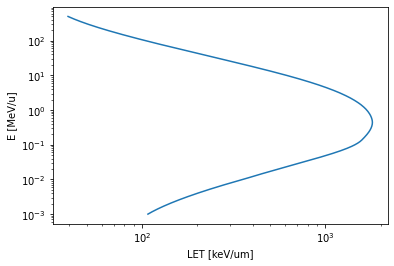

In [33]:
e_test_MeV_u = np.geomspace(start = 1 * keV_u, stop = 500 * MeV_u, num = 500)

plt.plot( glet(e_test_MeV_u, Z=12, libamtrack=True),e_test_MeV_u, label = "C")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("E [MeV/u]")
plt.xlabel("LET [keV/um]")
plt.legend

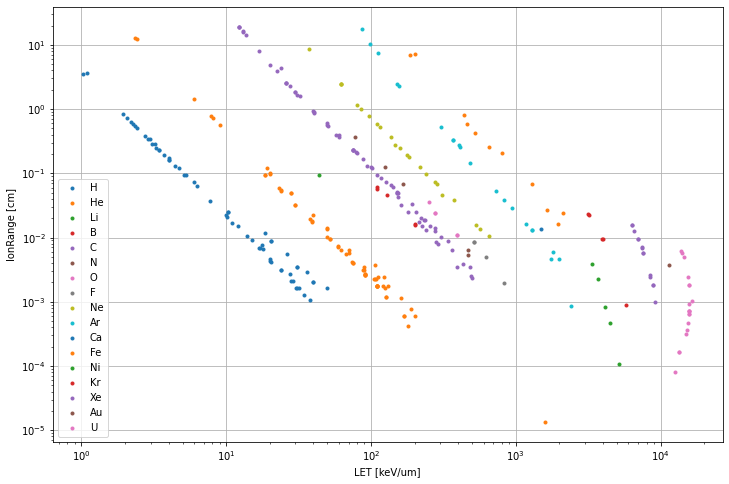

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
for ion_charge, ion_df in v79_df.groupby('Charge'):
  ion_df.plot('LET_keV_um', 'IonRange_cm', style='.', label="{}".format(periodictable.elements[ion_charge]), ax=ax);
ax.set_xlabel('LET [keV/um]')
ax.set_ylabel('IonRange [cm]')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid();

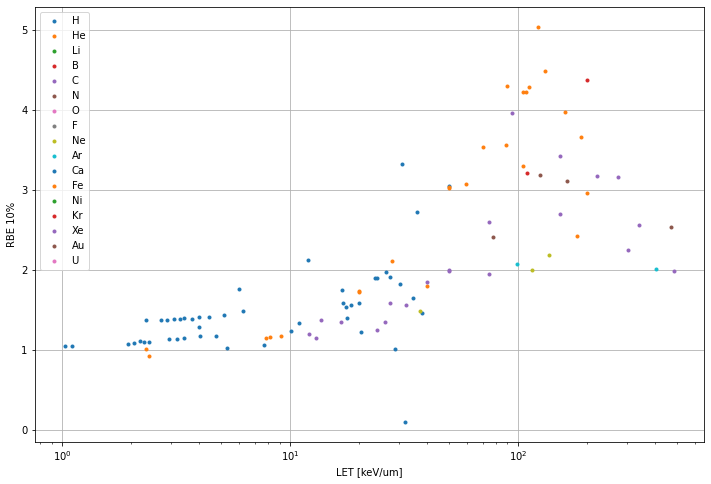

In [35]:
fig, ax = plt.subplots(figsize=(12,8))
for ion_charge, ion_df in v79_df.groupby('Charge'):
  ion_df.plot('LET_keV_um', 'RBE10', style='.', label="{}".format(periodictable.elements[ion_charge]), ax=ax);
ax.set_xlabel('LET [keV/um]')
ax.set_ylabel('RBE 10%')
ax.set_xscale('log')
ax.grid();

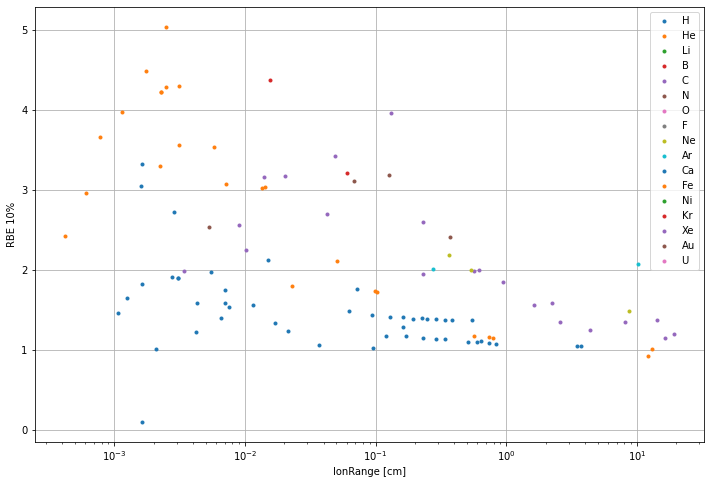

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
for ion_charge, ion_df in v79_df.groupby('Charge'):
  ion_df.plot('IonRange_cm', 'RBE10', style='.', label="{}".format(periodictable.elements[ion_charge]), ax=ax);
ax.set_xlabel('IonRange [cm]')
ax.set_ylabel('RBE 10%')
ax.set_xscale('log')
ax.grid();

# Range filter

In [37]:
range_threshold_cm = 0.1

Entries: 102


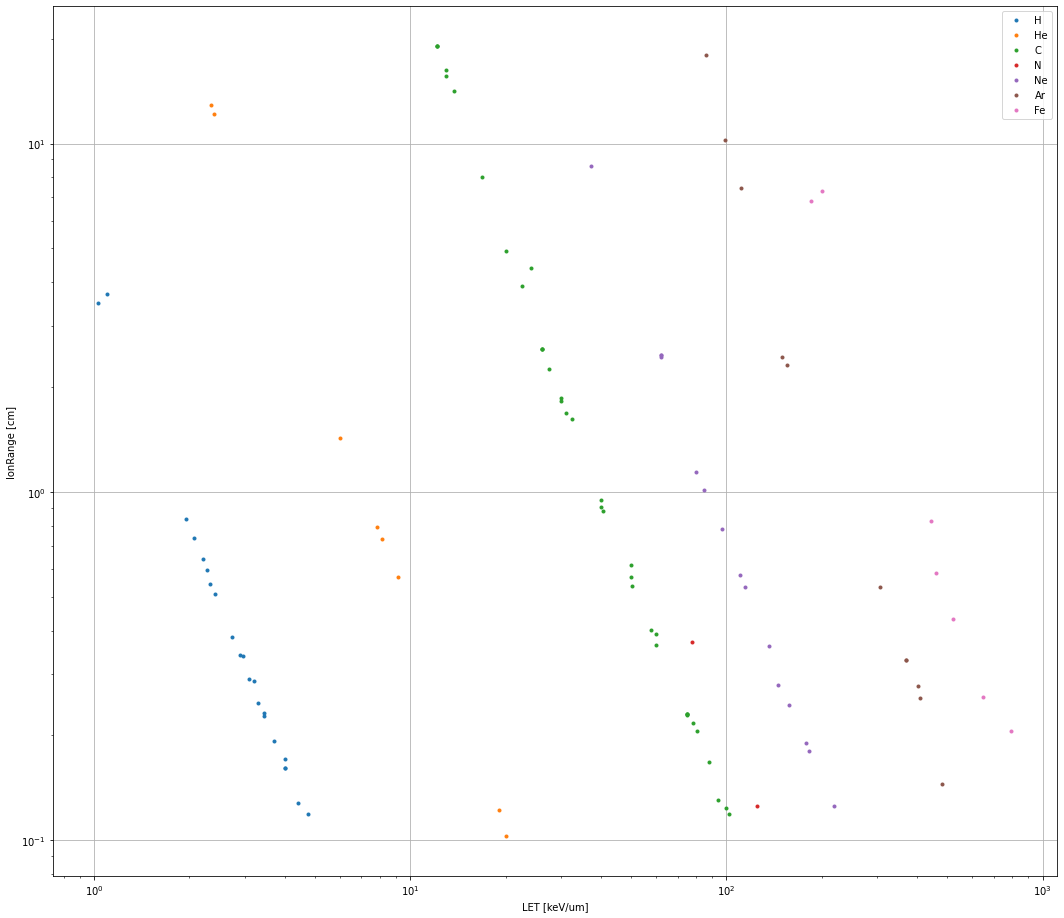

In [38]:
fig, ax = plt.subplots(figsize=(18,16))
range_df = v79_df[v79_df.IonRange_cm > range_threshold_cm]
for ion_charge, ion_df in range_df.groupby('Charge'):
  ion_df.plot('LET_keV_um', 'IonRange_cm', style='.', label="{}".format(periodictable.elements[ion_charge]), ax=ax);
ax.set_xlabel('LET [keV/um]')
ax.set_ylabel('IonRange [cm]')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid();
print("Entries:" , len(range_df))

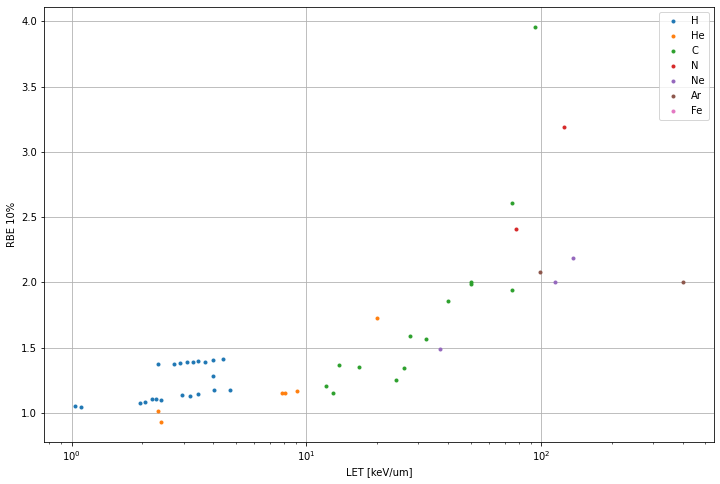

In [39]:
fig, ax = plt.subplots(figsize=(12,8))
for ion_charge, ion_df in range_df.groupby('Charge'):
  ion_df.plot('LET_keV_um', 'RBE10', style='.', label="{}".format(periodictable.elements[ion_charge]), ax=ax);
ax.set_xlabel('LET [keV/um]')
ax.set_ylabel('RBE 10%')
ax.set_xscale('log')
ax.grid();

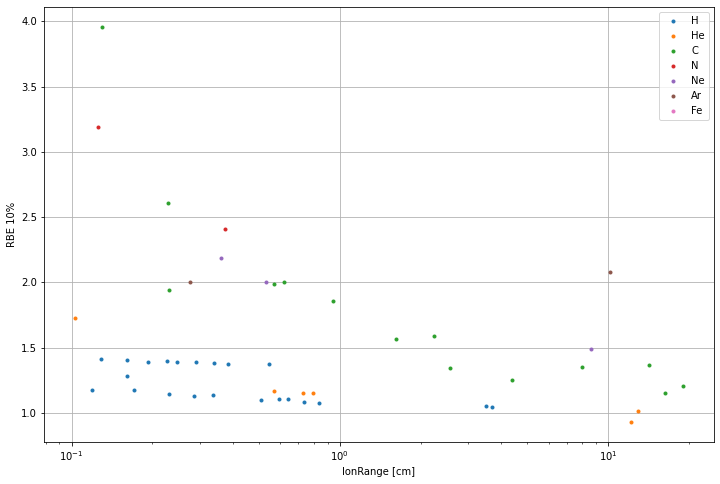

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
for ion_charge, ion_df in range_df.groupby('Charge'):
  ion_df.plot('IonRange_cm', 'RBE10', style='.', label="{}".format(periodictable.elements[ion_charge]), ax=ax);
ax.set_xlabel('IonRange [cm]')
ax.set_ylabel('RBE 10%')
ax.set_xscale('log')
ax.grid();

In [41]:
len(range_df.groupby('Charge'))

7

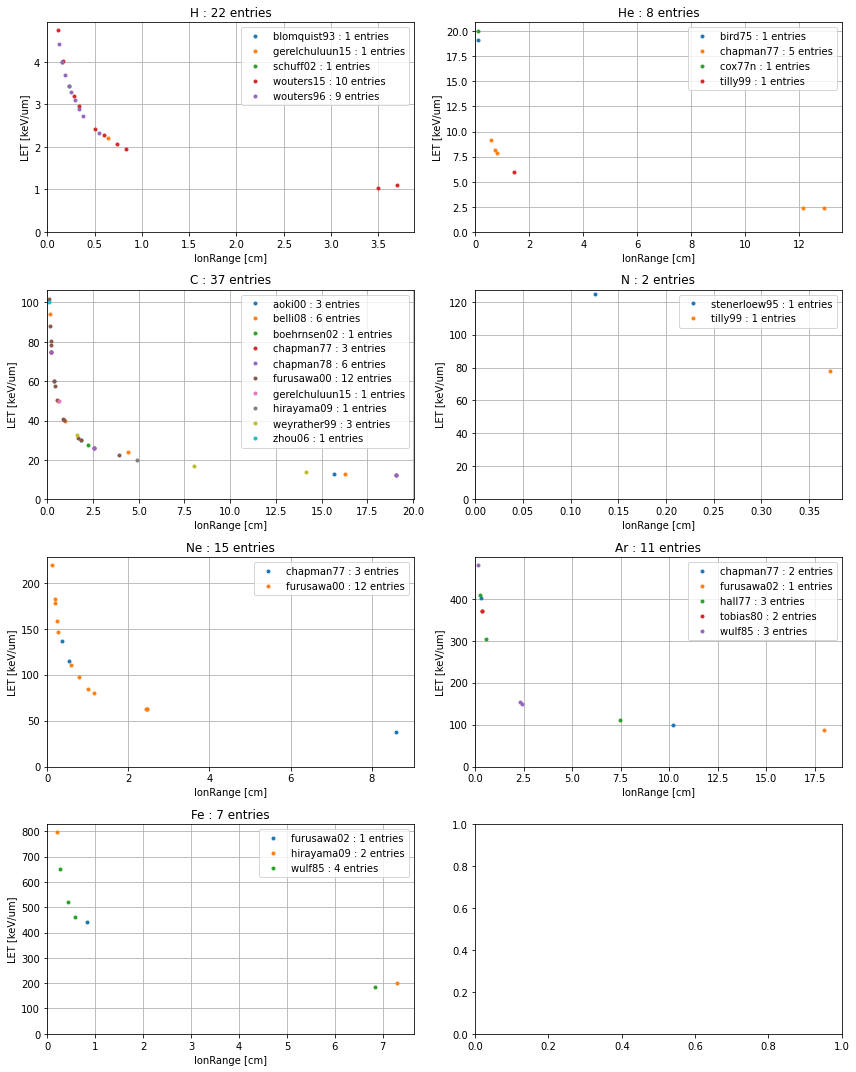

In [42]:
fig, ax = plt.subplots(4,2, figsize=(12,15))
for a, (ion_charge, ion_df) in zip(ax.flatten()[:-1], range_df.groupby('Charge')):
  a.set_title("{} : {} entries".format(periodictable.elements[ion_charge], len(ion_df)))
  for publ_name, publ_df in ion_df.groupby('PublicationName'):    
    label = '{} : {} entries'.format(publ_name, len(publ_df))
    publ_df.plot('IonRange_cm', 'LET_keV_um', style='.', label=label, ax=a);
  a.set_ylabel('LET [keV/um]')
  a.set_xlabel('IonRange [cm]')
  a.grid();
  a.set_ylim(0,None)
  a.set_xlim(0,None)
  #a.set_yscale('log')
  #a.set_xscale('log')
fig.tight_layout()

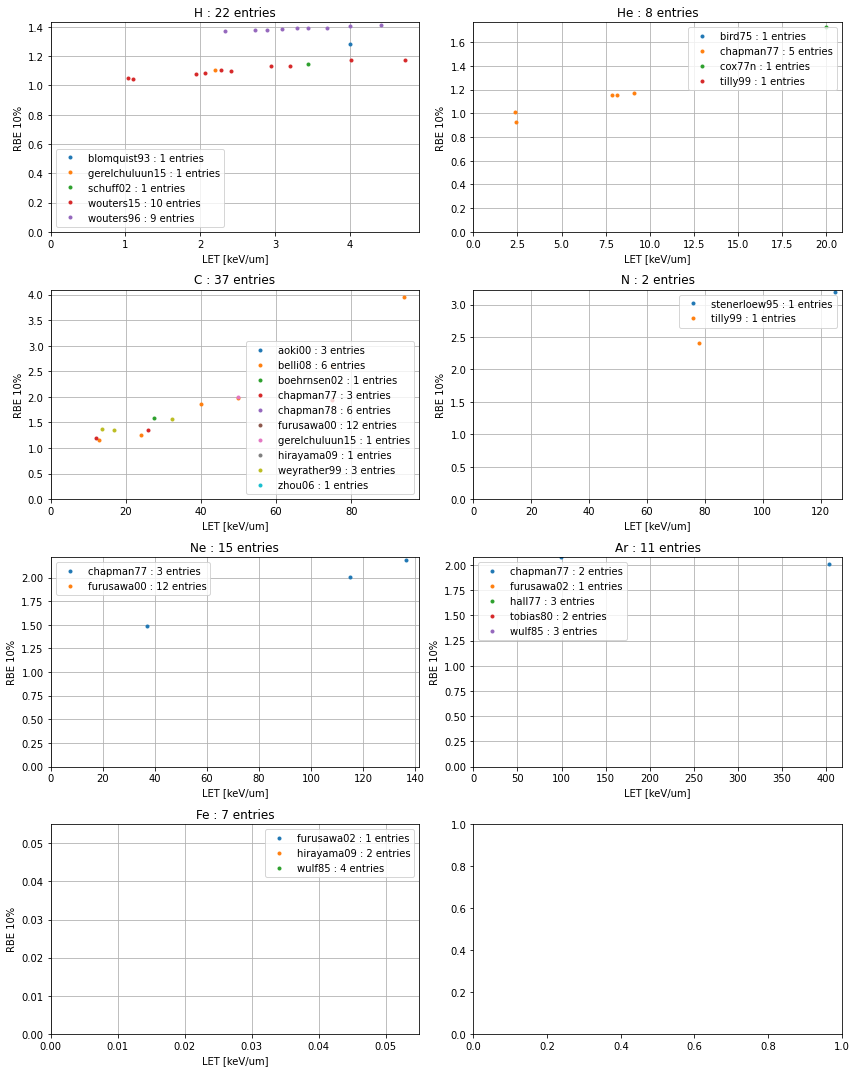

In [43]:
fig, ax = plt.subplots(4,2, figsize=(12,15))
for a, (ion_charge, ion_df) in zip(ax.flatten()[:-1], range_df.groupby('Charge')):
  a.set_title("{} : {} entries".format(periodictable.elements[ion_charge], len(ion_df)))
  for publ_name, publ_df in ion_df.groupby('PublicationName'):    
    label = '{} : {} entries'.format(publ_name, len(publ_df))
    publ_df.plot('LET_keV_um', 'RBE10', style='.', label=label, ax=a);
  a.set_xlabel('LET [keV/um]')
  a.set_ylabel('RBE 10%')
  a.grid();
  a.set_ylim(0,None)
  a.set_xlim(0,None)
fig.tight_layout()

# Pristine BP filter

Entries: 55


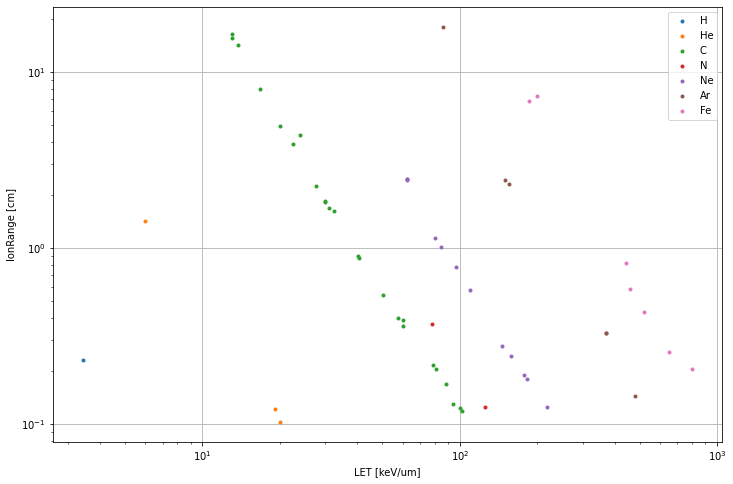

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
bp_df = range_df[range_df.IrradiationConditions == 'm']
for ion_charge, ion_df in bp_df.groupby('Charge'):
  ion_df.plot('LET_keV_um', 'IonRange_cm', style='.', label="{}".format(periodictable.elements[ion_charge]), ax=ax);
ax.set_xlabel('LET [keV/um]')
ax.set_ylabel('IonRange [cm]')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid();
print("Entries:" , len(bp_df))

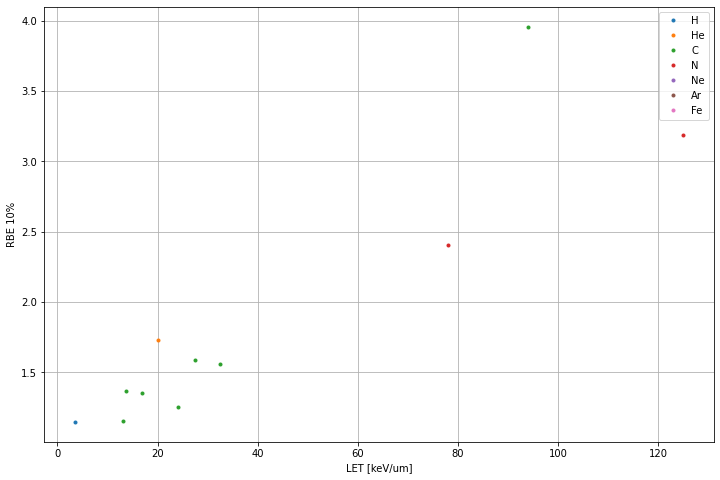

In [45]:
fig, ax = plt.subplots(figsize=(12,8))
for ion_charge, ion_df in bp_df.groupby('Charge'):
  ion_df.plot('LET_keV_um', 'RBE10', style='.', label="{}".format(periodictable.elements[ion_charge]), ax=ax);
ax.set_xlabel('LET [keV/um]')
ax.set_ylabel('RBE 10%')
#ax.set_xscale('log')
ax.grid();

In [46]:
len(bp_df.groupby('Charge'))

7

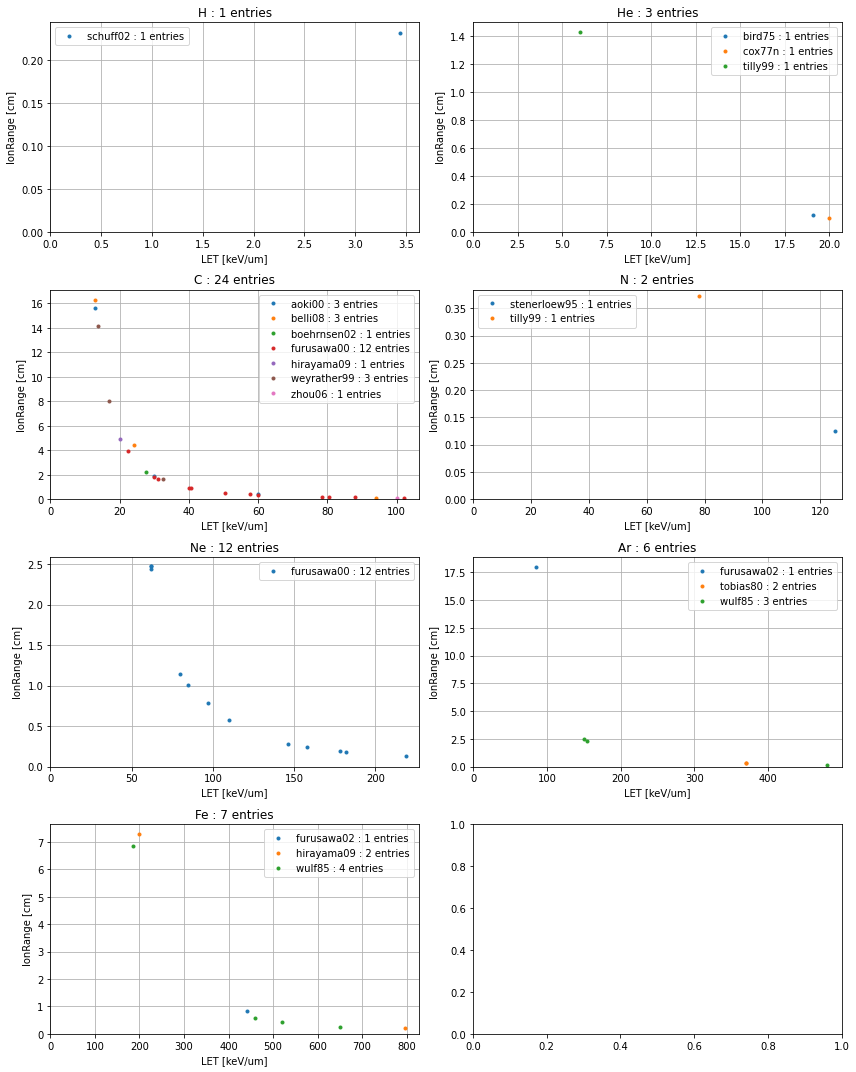

In [47]:
fig, ax = plt.subplots(4,2, figsize=(12,15))
for a, (ion_charge, ion_df) in zip(ax.flatten()[:-1], bp_df.groupby('Charge')):
  a.set_title("{} : {} entries".format(periodictable.elements[ion_charge], len(ion_df)))
  for publ_name, publ_df in ion_df.groupby('PublicationName'):    
    label = '{} : {} entries'.format(publ_name, len(publ_df))
    publ_df.plot('LET_keV_um', 'IonRange_cm', style='.', label=label, ax=a);
  a.set_xlabel('LET [keV/um]')
  a.set_ylabel('IonRange [cm]')
  a.grid();
  a.set_ylim(0,None)
  a.set_xlim(0,None)
  #a.set_yscale('log')
  #a.set_xscale('log')
fig.tight_layout()

# Data filter

In [48]:
def lq(x, alpha, beta):
    return (-alpha*x-beta*x**2)
params = Parameters()
params.add('alpha', value=0.0002, min=0)
params.add('beta', value=0.0001, min=0, max=1e8)
lqmodel = Model(lq, nanpolicy='omit')

In [49]:
def rbe10(ion_doses,  ion_cell_survival, ref_doses, ref_cell_survival):
  if not ion_doses:
    return np.nan

  ion_result = lqmodel.fit(params=params,data=np.log(ion_cell_survival), x=ion_doses)
  ref_result = lqmodel.fit(params=params,data=np.log(ref_cell_survival), x=ref_doses)
  #print(label, row.RBE10, ion_result.values['alpha'], ion_result.values['beta'], ref_result.values['alpha'], ref_result.values['beta'])

  if ion_result.values['beta'] > 0:
    ion_d10 = ((ion_result.values['alpha'] * ion_result.values['alpha'] - 4.0 * ion_result.values['beta'] * np.log(0.1))**0.5 - ion_result.values['alpha']) / (2.0 * ion_result.values['beta'])
  else:
    ion_d10 = np.log(0.1) / ( - ion_result.values['alpha'] )

  if ref_result.values['beta'] > 0:
    ref_d10 = ((ref_result.values['alpha'] * ref_result.values['alpha'] - 4.0 * ref_result.values['beta'] * np.log(0.1))**0.5 - ref_result.values['alpha']) / (2.0 * ref_result.values['beta'])
  else:
    ref_d10 = np.log(0.1) / ( - ref_result.values['alpha'] )
  
  rbe10 = ref_d10 / ion_d10

  return rbe10

In [50]:
ion_df_merged = pd.merge(left=bp_df, right=ion_raw_df, on=['#Publication', '#IonExp', '#PhotonExp', 'PublicationName'])
print("Entries before merge : ", len(bp_df))
print("Entries after merge : ", len(ion_df_merged))
ion_df_merged.drop(columns=['#ExpID_x', '#ExpID_y'], inplace=True)
ion_df_merged.head()


Entries before merge :  55
Entries after merge :  55


,#Publication,PublicationName,#IonExp,Cells,PhotonRadiation,#PhotonExp,Ion,Charge,IrradiationConditions,LET_keV_um,E_MeV_u,IonRange_cm,RBE10,ion_doses,ion_cell_survival,ion_no_doses,ion_no_cell_survival
0,12,weyrather99,1,V79,250kVp,1,12C,6,m,13.7,266.4,14.145937,1.369250,"[0.498, 1.198, 2.359, 3.514, 4.652, 5.788, 6.939]","[0.9272, 0.7893, 0.498, 0.3024, 0.1767, 0.097,...",7,7
1,12,weyrather99,2,V79,250kVp,1,12C,6,m,16.8,190.7,8.018652,1.350292,"[-0.004, 0.767, 2.335, 3.119, 3.897]","[1.0, 0.8103, 0.5103, 0.365, 0.2683]",5,5
2,12,weyrather99,3,V79,250kVp,1,12C,6,m,32.4,76.9,1.619806,1.562080,"[0.511, 1.009, 1.515, 2.5, 3.499, 4.485, 5.464...","[0.8679, 0.7572, 0.579, 0.3338, 0.2129, 0.1655...",8,8
3,13,furusawa00,21,V79,200kVp,1,12C,6,m,22.5,126.0,3.895975,NaN,"[0.0, 2.0, 6.0, 8.0, 10.0, 12.0]","[1.0, 0.8223, 0.07566, 0.01217, 0.00132, 0.00037]",6,6
4,13,furusawa00,22,V79,200kVp,1,12C,6,m,30.0,82.3,1.828944,NaN,"[0.0, 1.5, 3.0, 4.5, 6.0, 7.5, 9.0]","[1.0, 0.7259, 0.3584, 0.1282, 0.04133, 0.01395...",7,7


In [51]:
photon_raw_df.head()

,#ExpID,#Publication,PublicationName,#PhotonExp,ref_doses,ref_cell_survival,ref_no_doses,ref_no_cell_survival
0,1,1,chapman77,1,[],[],0,0
1,2,2,chapman78,1,"[0.62, 1.32, 2.1, 2.87, 4.04, 5.51, 6.95, 8.31...","[0.91201, 0.81283, 0.69183, 0.6166, 0.40738, 0...",10,10
2,3,2,chapman78,2,"[0.66, 1.4, 2.14, 2.91, 3.69, 5.32, 6.95, 7.96...","[0.93325, 0.83176, 0.66069, 0.44668, 0.33884, ...",10,10
3,4,2,chapman78,3,"[0.94, 1.96, 2.98, 3.96, 4.94, 5.96, 6.98, 7.92]","[0.83176, 0.67608, 0.46774, 0.30903, 0.19498, ...",8,8
4,5,3,blakely79,1,"[2.91, 4.617, 4.65, 5.615, 7.365, 7.383, 7.392...","[0.429, 0.1869, 0.2043, 0.0963, 0.0336, 0.0373...",12,12


In [52]:
ref_df_merged = pd.merge(left=ion_df_merged, right=photon_raw_df, on=['#Publication', '#PhotonExp', 'PublicationName'])
ref_df_merged['rbe10'] = ref_df_merged.apply(lambda x : rbe10(x.ion_doses,  x.ion_cell_survival, x.ref_doses, x.ref_cell_survival), axis=1)
print("Entries before merge : ", len(ion_df_merged))
print("Entries after merge : ", len(ref_df_merged))
ref_df_merged.head()

Entries before merge :  55
Entries after merge :  55


,#Publication,PublicationName,#IonExp,Cells,PhotonRadiation,#PhotonExp,Ion,Charge,IrradiationConditions,LET_keV_um,E_MeV_u,IonRange_cm,RBE10,ion_doses,ion_cell_survival,ion_no_doses,ion_no_cell_survival,#ExpID,ref_doses,ref_cell_survival,ref_no_doses,ref_no_cell_survival,rbe10
0,12,weyrather99,1,V79,250kVp,1,12C,6,m,13.7,266.4,14.145937,1.369250,"[0.498, 1.198, 2.359, 3.514, 4.652, 5.788, 6.939]","[0.9272, 0.7893, 0.498, 0.3024, 0.1767, 0.097,...",7,7,30,"[0.78, 1.028, 1.424, 1.826, 2.024, 2.535, 2.78...","[1.0431, 0.9394, 0.8697, 0.825, 0.7405, 0.7296...",19,19,1.365071
1,12,weyrather99,2,V79,250kVp,1,12C,6,m,16.8,190.7,8.018652,1.350292,"[-0.004, 0.767, 2.335, 3.119, 3.897]","[1.0, 0.8103, 0.5103, 0.365, 0.2683]",5,5,30,"[0.78, 1.028, 1.424, 1.826, 2.024, 2.535, 2.78...","[1.0431, 0.9394, 0.8697, 0.825, 0.7405, 0.7296...",19,19,1.336867
2,12,weyrather99,3,V79,250kVp,1,12C,6,m,32.4,76.9,1.619806,1.562080,"[0.511, 1.009, 1.515, 2.5, 3.499, 4.485, 5.464...","[0.8679, 0.7572, 0.579, 0.3338, 0.2129, 0.1655...",8,8,30,"[0.78, 1.028, 1.424, 1.826, 2.024, 2.535, 2.78...","[1.0431, 0.9394, 0.8697, 0.825, 0.7405, 0.7296...",19,19,1.567314
3,13,furusawa00,21,V79,200kVp,1,12C,6,m,22.5,126.0,3.895975,NaN,"[0.0, 2.0, 6.0, 8.0, 10.0, 12.0]","[1.0, 0.8223, 0.07566, 0.01217, 0.00132, 0.00037]",6,6,33,"[-0.003, 0.99, 3.008, 5.004, 6.968, 9.027, 11....","[1.0, 0.8866, 0.4824, 0.2425, 0.1021, 0.0359, ...",7,7,1.325875
4,13,furusawa00,22,V79,200kVp,1,12C,6,m,30.0,82.3,1.828944,NaN,"[0.0, 1.5, 3.0, 4.5, 6.0, 7.5, 9.0]","[1.0, 0.7259, 0.3584, 0.1282, 0.04133, 0.01395...",7,7,33,"[-0.003, 0.99, 3.008, 5.004, 6.968, 9.027, 11....","[1.0, 0.8866, 0.4824, 0.2425, 0.1021, 0.0359, ...",7,7,1.420335


Entries: 24


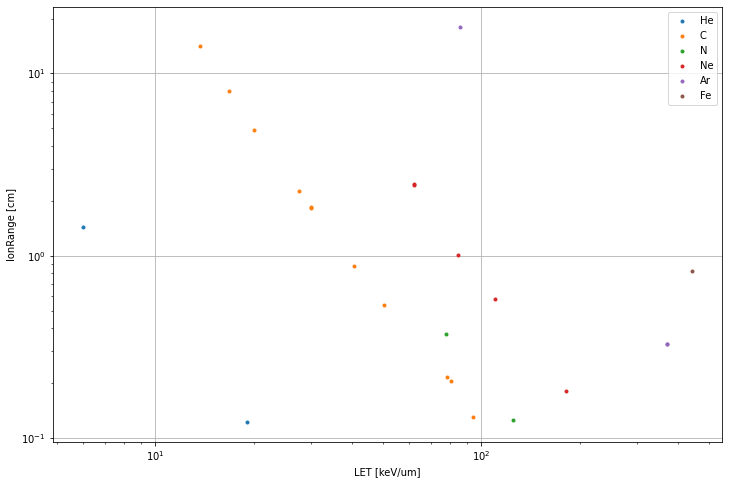

In [53]:
fig, ax = plt.subplots(figsize=(12,8))
data_df = ref_df_merged[(ref_df_merged.ref_no_doses > 0) & (ref_df_merged.ion_no_doses)]
for ion_charge, ion_df in data_df.groupby('Charge'):
  ion_df.plot('LET_keV_um', 'IonRange_cm', style='.', label="{}".format(periodictable.elements[ion_charge]), ax=ax);
ax.set_xlabel('LET [keV/um]')
ax.set_ylabel('IonRange [cm]')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid();
print("Entries:" , len(data_df))

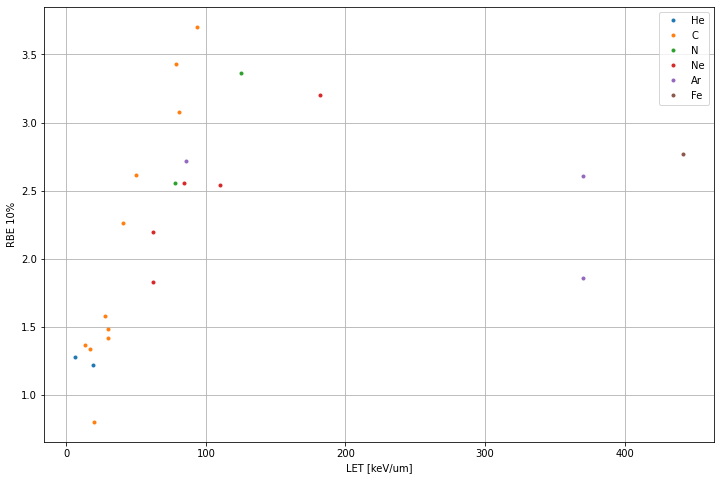

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
for ion_charge, ion_df in data_df.groupby('Charge'):
  ion_df.plot('LET_keV_um', 'rbe10', style='.', label="{}".format(periodictable.elements[ion_charge]), ax=ax);
ax.set_xlabel('LET [keV/um]')
ax.set_ylabel('RBE 10%')
#ax.set_xscale('log')
ax.grid();

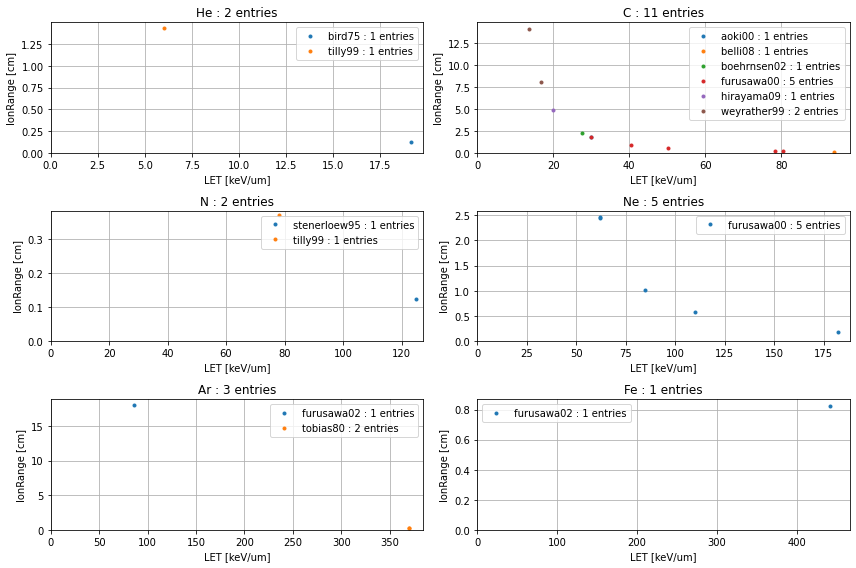

In [55]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
for a, (ion_charge, ion_df) in zip(ax.flatten(), data_df.groupby('Charge')):
  a.set_title("{} : {} entries".format(periodictable.elements[ion_charge], len(ion_df)))
  for publ_name, publ_df in ion_df.groupby('PublicationName'):    
    label = '{} : {} entries'.format(publ_name, len(publ_df))
    publ_df.plot('LET_keV_um', 'IonRange_cm', style='.', label=label, ax=a);
  a.set_xlabel('LET [keV/um]')
  a.set_ylabel('IonRange [cm]')
  a.grid();
  a.set_ylim(0,None)
  a.set_xlim(0,None)
fig.tight_layout()

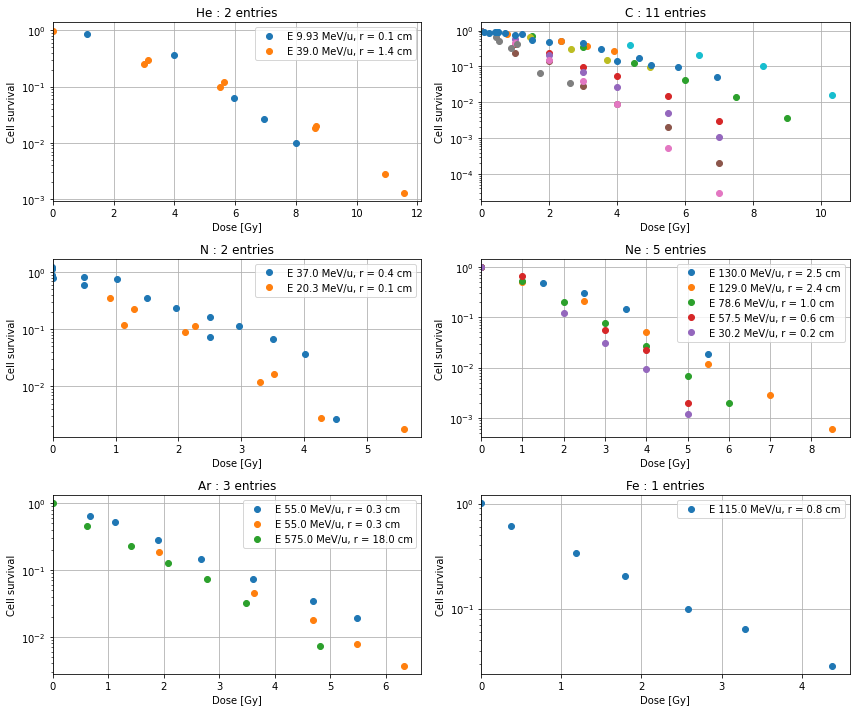

In [56]:
fig, ax = plt.subplots(3,2, figsize=(12,10))
for a, (ion_charge, ion_df) in zip(ax.flatten(), data_df.groupby('Charge')):
  a.set_title("{} : {} entries".format(periodictable.elements[ion_charge], len(ion_df)))
  for index, row in ion_df.iterrows():
    label = 'E {} MeV/u, r = {:3.1f} cm'.format(row.E_MeV_u, row.IonRange_cm)
    a.plot(row.ion_doses, row.ion_cell_survival, linestyle='', marker='o', label=label)
  a.set_xlabel('Dose [Gy]')
  a.set_ylabel('Cell survival')
  if len(ion_df) < 6:
    a.legend(loc=0)
  a.grid();
  a.set_yscale('log')
  a.set_xlim(0,None)
fig.tight_layout()

In [57]:
data_df[['Ion', 'E_MeV_u', 'LET_keV_um', 'IonRange_cm', 'rbe10', 'PublicationName', 'PhotonRadiation']].sort_values(by=['Ion', 'E_MeV_u'])

,Ion,E_MeV_u,LET_keV_um,IonRange_cm,rbe10,PublicationName,PhotonRadiation
29,12C,19.00,94.0,0.130281,3.703593,belli08,60Co/137Cs
12,12C,24.50,80.6,0.206016,3.078169,furusawa00,200kVp
11,12C,25.20,78.5,0.216760,3.427445,furusawa00,200kVp
8,12C,41.70,50.3,0.538343,2.617349,furusawa00,200kVp
7,12C,54.80,40.6,0.881236,2.262345,furusawa00,200kVp
4,12C,82.30,30.0,1.828944,1.420335,furusawa00,200kVp
32,12C,83.00,30.0,1.856841,1.482056,aoki00,200kVp
41,12C,92.50,27.5,2.252990,1.581306,boehrnsen02,6MV
38,12C,144.00,20.0,4.925013,0.802574,hirayama09,200kVp
1,12C,190.70,16.8,8.018652,1.336867,weyrather99,250kVp


In [58]:
len(data_df)

24

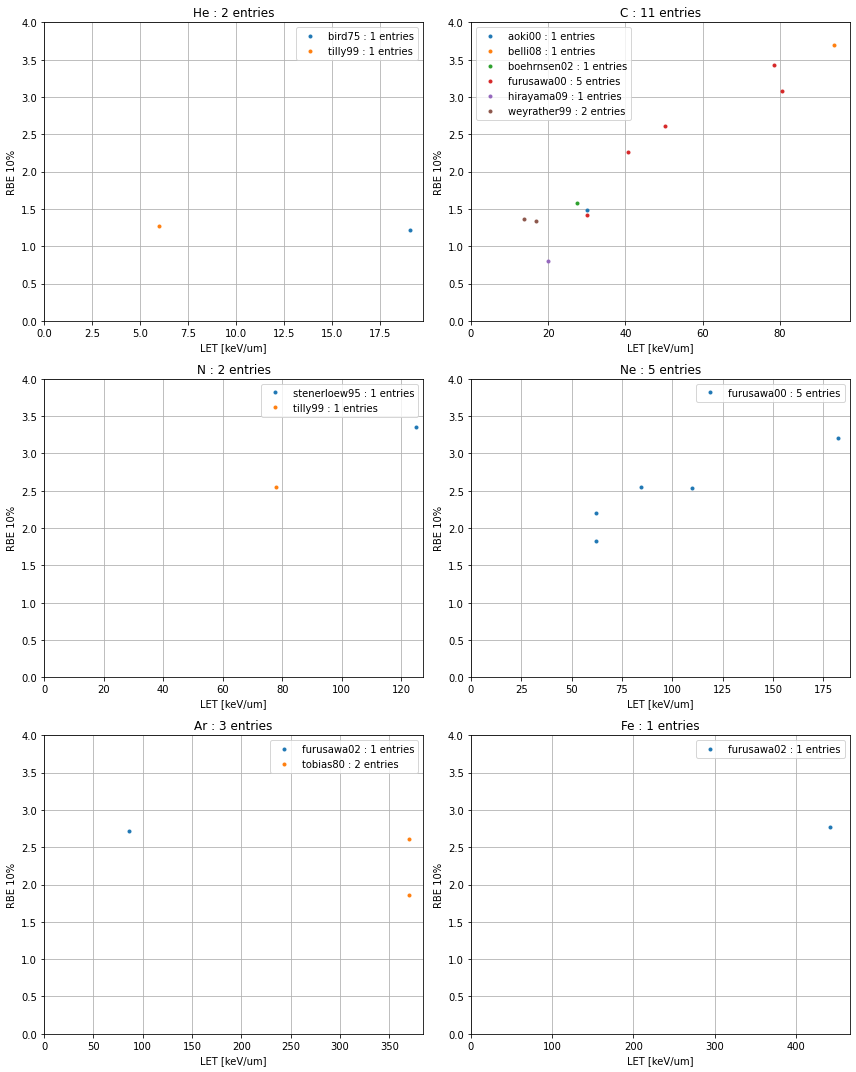

In [59]:
fig, ax = plt.subplots(3,2, figsize=(12,15))
for a, (ion_charge, ion_df) in zip(ax.flatten(), data_df.groupby('Charge')):
  a.set_title("{} : {} entries".format(periodictable.elements[ion_charge], len(ion_df)))
  for publ_name, publ_df in ion_df.groupby('PublicationName'):    
    label = '{} : {} entries'.format(publ_name, len(publ_df))
    publ_df.plot('LET_keV_um', 'rbe10', style='.', label=label, ax=a);
  a.set_xlabel('LET [keV/um]')
  a.set_ylabel('RBE 10%')
  a.grid();
  a.set_ylim(0,4)
  a.set_xlim(0,None)
fig.tight_layout()

In [60]:
ref_df_merged[(ref_df_merged.ref_no_doses == 0) | (ref_df_merged.ion_no_doses == 0)][['Ion', 'E_MeV_u', 'LET_keV_um', 'IonRange_cm', 'rbe10', 'PublicationName', '#Publication']].sort_values(by=['Ion', 'E_MeV_u'])

,Ion,E_MeV_u,LET_keV_um,IonRange_cm,rbe10,PublicationName,#Publication
54,1H,14.2,3.44,0.231610,NaN,schuff02,113
42,40Ar,35.0,480.00,0.145316,NaN,wulf85,49
43,40Ar,165.0,155.00,2.312602,NaN,wulf85,49
44,40Ar,170.0,150.00,2.435453,NaN,wulf85,49
53,4He,9.0,20.00,0.102617,NaN,cox77n,83
45,56Fe,60.0,650.00,0.257841,NaN,wulf85,49
46,56Fe,80.0,520.00,0.432064,NaN,wulf85,49
47,56Fe,95.0,460.00,0.587155,NaN,wulf85,49
48,56Fe,400.0,185.00,6.846194,NaN,wulf85,49
